파이썬 딥러닝 파이토치(이경택, 방성수, 안성준 지음) 예제로 pytorch 연습하기



사람의 손글씨 데이터인 MNIST를 이용해 MLP 모델 설계하기

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [5]:
if torch.cuda.is_available():
  DEVICE=torch.device('cuda')
else:
  DEVICE=torch.device('cpu')

print(f"Using PyTorch version: {torch.__version__,}, 'DEVICE: {DEVICE}") 

Using PyTorch version: ('1.9.0+cu102',), 'DEVICE: cuda


In [6]:
BATCH_SIZE=32
EPOCHS=10

MNIST 데이터 다운로드

- 코랩에서 파이토치로 MNIST 데이터 다운 받기

- https://www.infoking.site/51


In [11]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

In [13]:
df_train=pd.read_csv('./sample_data/mnist_train_small.csv', header=None)
df_test=pd.read_csv('./sample_data/mnist_test.csv', header=None)

In [16]:
train_labels=df_train.iloc[:, 0]
train_images=df_train.iloc[:, 1:]
test_labels=df_test.iloc[:, 0]
test_images=df_test.iloc[:, 1:]

In [18]:
transform=transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))
    ]
)

In [19]:
class MNISTDataset(Dataset):
  def __init__(self, images, labels=None, transforms=None):
    self.X=images
    self.y=labels
    self.transforms=transforms
  def __len__(self):
    return(len(self.X))
  def __getitem__(self,i):
    data=self.X.iloc[i, :]
    data=np.asarray(data).astype(np.uint8).reshape(28,28,1)

    if self.transforms:
      data=self.transforms(data)
    if self.y is not None:
      return (data, self.y[i])
    else:
      return data

In [20]:
train_data=MNISTDataset(train_images, train_labels, transform)
test_data=MNISTDataset(test_images, test_labels, transform)
train_loader=DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader=DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print("y_train", y_train.size(), "type:", y_train.type())
  break

X_train: torch.Size([32, 1, 32, 32]) type: torch.FloatTensor
y_train torch.Size([32]) type: torch.LongTensor


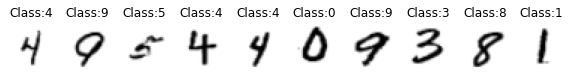

In [24]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].numpy().reshape(32,32), cmap="gray_r")
  plt.title("Class:"+str(y_train[i].item()))

MLP(Milti Layer Perceptron) 모델 설계하기

In [25]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1=nn.Linear(32*32, 512)
    self.fc2=nn.Linear(512, 256)
    self.fc3=nn.Linear(256, 10)
  def forward(self, x):
    x=x.view(-1, 32*32)
    x=self.fc1(x)
    x=F.sigmoid(x)
    x=self.fc2(x)
    x=F.sigmoid(x)
    x=self.fc3(x)
    x=F.log_softmax(x, dim=1)
    return x

In [26]:
model=Net().to(DEVICE)
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion=nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


MLP 모델 학습을 진행하여 학습 데이터에 대한 모델 성능을 확인하는 함수 정의

In [35]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image=image.to(DEVICE)
    label=label.to(DEVICE)
    optimizer.zero_grad()
    output=model(image)
    loss=criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx%log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)] \t Train Loss: {:.6f}".format(Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))

학습의 진행과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

In [36]:
def evaluate(model, test_loader):
  model.eval()
  test_loss=0
  correct=0

  with torch.no_grad():
    for image, label in test_loader:
      image=image.to(DEVICE)
      label=label.to(DEVICE)
      output=model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim=True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()
  
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100.*correct/len(test_loader.dataset)
  return test_loss, test_accuracy

모델 적용해보기

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model, test_loader)
  print("\n [EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f} \n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/20000(0%)] 	 Train Loss: 2.317579
Train Epoch: 1 [6400/20000(32%)] 	 Train Loss: 2.244676
Train Epoch: 1 [12800/20000(64%)] 	 Train Loss: 2.193184
Train Epoch: 1 [19200/20000(96%)] 	 Train Loss: 2.094069

 [EPOCH: 1], 	 Test Loss: 0.0661, 	 Test Accuracy: 37.69 

Train Epoch: 2 [0/20000(0%)] 	 Train Loss: 2.153683
Train Epoch: 2 [6400/20000(32%)] 	 Train Loss: 1.831045
Train Epoch: 2 [12800/20000(64%)] 	 Train Loss: 1.712312
Train Epoch: 2 [19200/20000(96%)] 	 Train Loss: 1.502477

 [EPOCH: 2], 	 Test Loss: 0.0443, 	 Test Accuracy: 56.75 

Train Epoch: 3 [0/20000(0%)] 	 Train Loss: 1.396873
Train Epoch: 3 [6400/20000(32%)] 	 Train Loss: 1.213174
Train Epoch: 3 [12800/20000(64%)] 	 Train Loss: 1.117683
Train Epoch: 3 [19200/20000(96%)] 	 Train Loss: 1.013553

 [EPOCH: 3], 	 Test Loss: 0.0288, 	 Test Accuracy: 75.37 

Train Epoch: 4 [0/20000(0%)] 	 Train Loss: 0.691825
Train Epoch: 4 [6400/20000(32%)] 	 Train Loss: 0.919796
Train Epoch: 4 [12800/20000(64%)] 	 Train Loss